# Анализ бизнес-показателей Яндекс.Афиши

## Содержание
1. [Описание проекта](#step1)
2. [Загрузка и подготовка данных к анализу](#step2)
3. [Построение отчётов и расчёт метрик](#step3)  
 - Продукт   
 - Продажи  
 - Маркетинг  
4. [Вывод](#step4)

<a id='step1'></a>

# 1. Описание проекта

**Задача** — помочь маркетологам оптимизировать маркетинговые затраты.  

**Данные:**  
C июня 2017 по конец мая 2018 года:  
- лог сервера с данными о посещениях сайта Яндекс.Афиши,  
- выгрузка всех заказов за этот период,  
- статистика рекламных расходов.

**Описание данных**

Таблица visits (лог сервера с информацией о посещениях сайта):  

Uid — уникальный идентификатор пользователя  
Device — категория устройства пользователя  
Start Ts — дата и время начала сессии  
End Ts — дата и время окончания сессии  
Source Id — идентификатор рекламного источника, из которого пришел пользователь  

Таблица orders (информация о заказах):  

Uid — уникальный id пользователя, который сделал заказ  
Buy Ts — дата и время заказа  
Revenue — выручка Яндекс.Афиши с этого заказа  

Таблица costs (информация о затратах на маркетинг):  

source_id — идентификатор рекламного источника  
dt — дата  
costs — затраты на этот рекламный источник в этот день  

[К содержанию](#Содержание)
<a id='step2'></a>

# 2. Загрузка и подготовка данных к анализу

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
np.warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs = pd.read_csv('datasets/costs.csv')

Данные о визитах:

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [5]:
# посмотрим, с каких устройств заходят пользователи
visits.device.unique()

array(['touch', 'desktop'], dtype=object)

In [6]:
# посмотрим, сколько и каких имеется источников привлечения пользователей
sorted(visits.source_id.unique())

[1, 2, 3, 4, 5, 6, 7, 9, 10]

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В данных о визитах пропущенных значений нет, переменные, содержащие время начала и окончания пользовательской сессии необходимо перевести в тип `datetime`.

In [8]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'],
                                    format='%Y-%m-%d %H:%M:%S')

Данные о заказах:

In [9]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В данных о заказах пропущенных знченией нет, переменную содержащую дату и время заказа, необходимо перевести в формат `datetime`.

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

Данные о расходах:

In [13]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропущенных значений нет, переменную, содержащую дату, переведем в `datetime`.

In [15]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

[К содержанию](#Содержание)
<a id='step3'></a>

# 3. Построение отчётов и расчёт метрик 

## Продукт

Рассчитаем, сколько людей пользуются продуктом в день, неделю и месяц. 
Для расчетов добавим переменные, содержащие год, месяц, неделю и день визита на сайт.

In [16]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_day'] = visits['start_ts'].dt.date

**Количество уникальных пользователей в день**

In [17]:
dau_total = visits.groupby('session_day').agg({'uid':'nunique'})
avg_dau_total = dau_total.mean()
print('Среднее количество уникальных пользователей в день: {}.'.format(
    int(round(avg_dau_total))))

Среднее количество уникальных пользователей в день: 908.


In [18]:
dau_desktop = visits[visits['device'] == 'desktop'].groupby(
    'session_day').agg({'uid':'nunique'})
avg_dau_desktop = dau_desktop.mean()
print('Среднее количество уникальных пользователей, заходящих с компьютера, \
в день: {}.'.format(int(round(avg_dau_desktop))))

Среднее количество уникальных пользователей, заходящих с компьютера, в день: 659.


In [19]:
dau_touch = visits[visits['device'] == 'touch'].groupby(
    'session_day').agg({'uid':'nunique'})
avg_dau_touch = dau_touch.mean()
print('Среднее количество уникальных пользователей, заходящих с планшета, \
в день: {}.'.format(int(round(avg_dau_touch))))

Среднее количество уникальных пользователей, заходящих с планшета, в день: 253.


In [20]:
# соберем полученные значения в итоговую таблицу
average_users_activity = pd.DataFrame(index=['total', 'desktop', 'touch'],
                              columns=['DAU','WAU', 'MAU'])
average_users_activity['DAU'] = [int(round(avg_dau_total)),
                        int(round(avg_dau_desktop)),
                        int(round(avg_dau_touch))]

Построим график количества пользователей в день по устройствам с указанием средних значений.

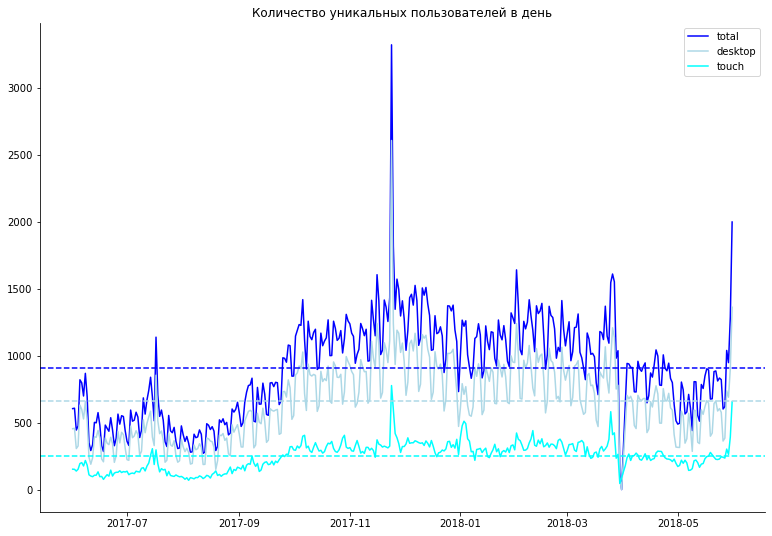

In [21]:
plt.figure(figsize=(13,9))
plt.plot(dau_total, label='total', color='blue')
plt.plot(dau_desktop, label='desktop', color='lightblue')
plt.plot(dau_touch, label='touch', color='cyan')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.axhline(y=int(round(avg_dau_total)), color='blue', linestyle='--')
plt.axhline(y=int(round(avg_dau_touch)), color='cyan', linestyle='--')
plt.axhline(y=int(round(avg_dau_desktop)), color='lightblue', linestyle='--')
plt.title('Количество уникальных пользователей в день');

Виден резкий подъем общего числа пользователей ближе к декабрю и значительное падение в апреле.  
С планшета в целом заходят значительно меньше.

**Количество уникальных пользователей в неделю**

In [22]:
wau_total = visits.groupby(['session_year', 'session_week']).agg(
    {'uid':'nunique'})
avg_wau_total = wau_total.mean()
print('Среднее количество уникальных пользователей в неделю: {}.'.format(
    int(round(avg_wau_total))))

Среднее количество уникальных пользователей в неделю: 5716.


In [23]:
wau_desktop = visits[visits['device']=='desktop'].groupby([
    'session_year', 'session_week']).agg({'uid':'nunique'}).mean()
avg_wau_desktop = wau_desktop.mean()
print('Среднее количество уникальных пользователей, заходящих с компьютера,\
в неделю:{}.'.format(int(round(avg_wau_desktop))))

Среднее количество уникальных пользователей, заходящих с компьютера,в неделю:4130.


In [24]:
wau_touch = visits[visits['device']=='touch'].groupby([
    'session_year', 'session_week']).agg({'uid':'nunique'})
avg_wau_touch = wau_touch.mean()
print('Среднее количество уникальных пользователей, заходящих с планшета, \
в неделю:{}.'.format(int(round(avg_wau_touch))))

Среднее количество уникальных пользователей, заходящих с планшета, в неделю:1635.


In [25]:
average_users_activity['WAU'] = [int(round(avg_wau_total)),
                        int(round(avg_wau_desktop)),
                        int(round(avg_wau_touch))]

**Количество уникальных пользователей в месяц**

In [26]:
mau_total = visits.groupby(['session_year', 'session_month']).agg(
    {'uid':'nunique'})
avg_mau_total = mau_total.mean()
print('Среднее количество уникальных пользователей в месяц: {}.'.format(
    int(round(avg_mau_total))))

Среднее количество уникальных пользователей в месяц: 23228.


In [27]:
mau_desktop = visits[visits['device']=='desktop'].groupby([
    'session_year', 'session_month']).agg({'uid':'nunique'})
avg_mau_desktop = mau_desktop.mean()
print('Среднее количество уникальных пользователей, заходящих с компьютера, \
в месяц: {}.'.format(int(round(avg_mau_desktop))))

Среднее количество уникальных пользователей, заходящих с компьютера, в месяц: 16725.


In [28]:
mau_touch = visits[visits['device']=='touch'].groupby([
    'session_year', 'session_month']).agg(
    {'uid':'nunique'})
avg_mau_touch = mau_touch.mean()
print('Среднее количество уникальных пользователей, заходящих с планшета, \
в месяц: {}.'.format(int(round(avg_mau_touch))))

Среднее количество уникальных пользователей, заходящих с планшета, в месяц: 6826.


In [29]:
average_users_activity['MAU'] = [int(round(avg_mau_total)),
                        int(round(avg_mau_desktop)),
                        int(round(avg_mau_touch))]

Построим график количества пользователей в месяц по устройствам с указанием средних значений.

In [30]:
# для меток горизонтальной оси
months = pd.date_range(visits.start_ts.astype('datetime64[M]').min(),
                       visits.start_ts.astype('datetime64[M]').max(),
                       freq='MS')
months = months.strftime('%Y-%m')
months

Index(['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05'],
      dtype='object')

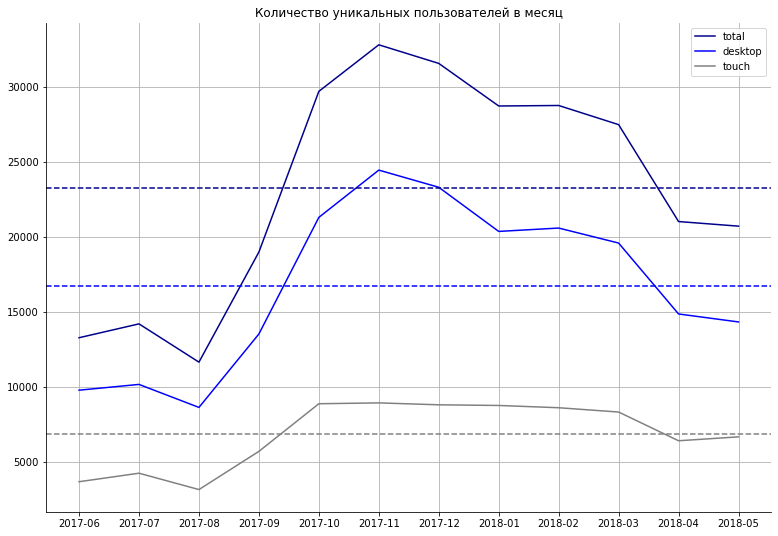

In [31]:
plt.figure(figsize=(13,9))
plt.plot(months, mau_total.reset_index()['uid'], label='total',
         color='darkblue')
plt.plot(months, mau_desktop.reset_index()['uid'], label='desktop',
         color='blue')
plt.plot(months, mau_touch.reset_index()['uid'], label='touch', color='grey')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.grid()
plt.axhline(y=int(round(avg_mau_total)), color='darkblue', linestyle='--')
plt.axhline(y=int(round(avg_mau_touch)), color='grey', linestyle='--')
plt.axhline(y=int(round(avg_mau_desktop)), color='blue', linestyle='--')
plt.title('Количество уникальных пользователей в месяц');

Действительно, максимум посещений приходится на ноябрь. Возможно, это связано с сезонностью: к ноябрю люди определяются, как будут проводить новогодние праздники, а летом заканчиваются театральные сезоны, люди уезжают в отпуска, на дачи и прочее.  
Возможно, с августа начал действовать некий эффективный источник привлечения пользователей. Посмотрим, как менялось количество посещений по разным источникам.

In [32]:
sources = visits['source_id'].unique()
sources

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [33]:
def plot_visits_by_source(s_id):
    plt.plot(visits[visits['source_id']==s_id].groupby([
        'session_year', 'session_month']).agg(
        {'uid':'nunique'}).reset_index()['uid'], label=s_id)

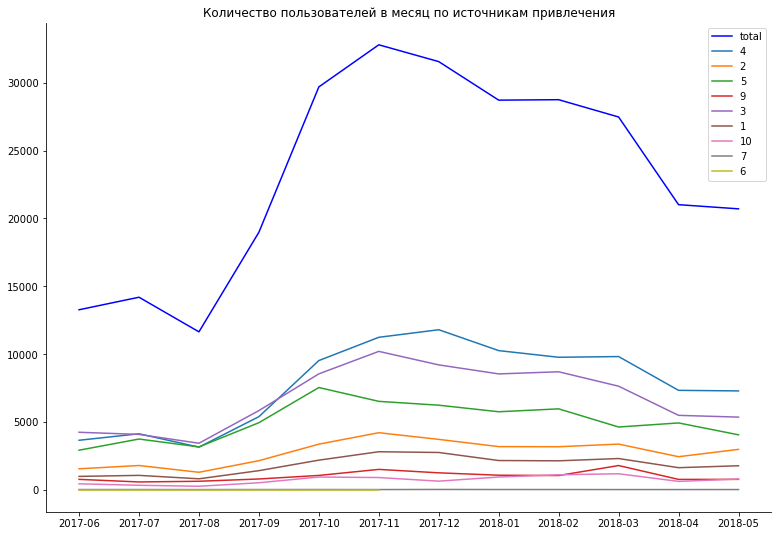

In [34]:
plt.figure(figsize=(13,9))
plt.plot(months, mau_total.reset_index()['uid'], label='total', color='blue')
for source in sources:
    plot_visits_by_source(source)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Количество пользователей в месяц по источникам привлечения');

Судя по графику, наиболее эффективные источники привлечения пользователей - 4, 3 и 5.  
Но в данном случае мы рассматривали только визиты пользователей. В ходе дальнейшего анализа будет рассмотрено, как тот или иной источник повлиял на покупки.

**Регулярность использования сервиса**

In [35]:
average_users_activity['sticky_factor'] = average_users_activity['DAU']/\
average_users_activity['WAU']

In [36]:
average_users_activity

,DAU,WAU,MAU,sticky_factor
total,908,5716,23228,0.158852
desktop,659,4130,16725,0.159564
touch,253,1635,6826,0.154740


Регулярность использования приложения по устройствам примерно одинакова.  
sticky_factor сильно меньше единицы, значит пользователи заходят далеко не каждый день, что неудивительно, учитывая характер предлагаемых услуг.

**Количество пользовательский сессий в день**

In [37]:
# находим количество пользователей и количество сессий в день
sessions = visits.groupby('session_day').agg({'uid':['count', 'nunique']})

In [38]:
sessions.columns = ['n_sessions', 'n_users']
sessions.head()

,n_sessions,n_users
session_day,,
2017-06-01,664,605
2017-06-02,658,608
2017-06-03,477,445
2017-06-04,510,476
2017-06-05,893,820


Построим график, отображающий соотношение количетсва пользователей и проведенных ими сессй в день.

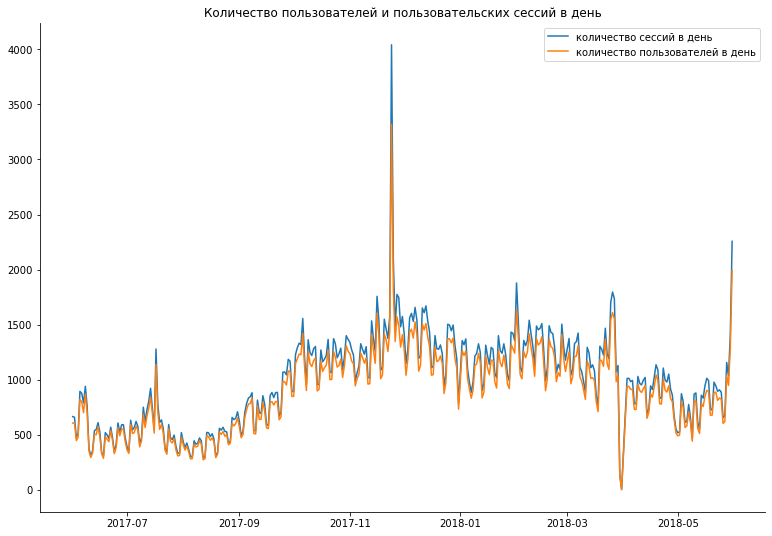

In [39]:
plt.figure(figsize=(13,9))
plt.title('Количество пользователей и пользовательских сессий в день')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(sessions['n_sessions'], label='количество сесcий в день')
plt.plot(sessions['n_users'], label='количество пользователей в день')
plt.legend();

Видно, что пользователь проводит в день в среднем около одной сессии. Рассчитаем это количество. 

In [40]:
print('В день клиенты проводят в среднем {} сессий'.format(
    int(round(sessions['n_sessions'].mean()))))

В день клиенты проводят в среднем 987 сессий


In [41]:
sessions_per_user = sessions.n_sessions/sessions.n_users

In [42]:
sessions_per_user.mean()

1.0821696440039723

В среднем на одного пользователя приходится одна сессия.

**Средняя длительность одной пользовательской сессии**

In [43]:
visits['asl'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [44]:
print('В среднем одна пользовательская сессия длится {} минут'.format(
    int(round(visits['asl'].mean()/60))))

В среднем одна пользовательская сессия длится 11 минут


Посмотрим на распределение длительности пользовательских сессий. 

In [45]:
visits['asl_min'] = visits['asl']/60

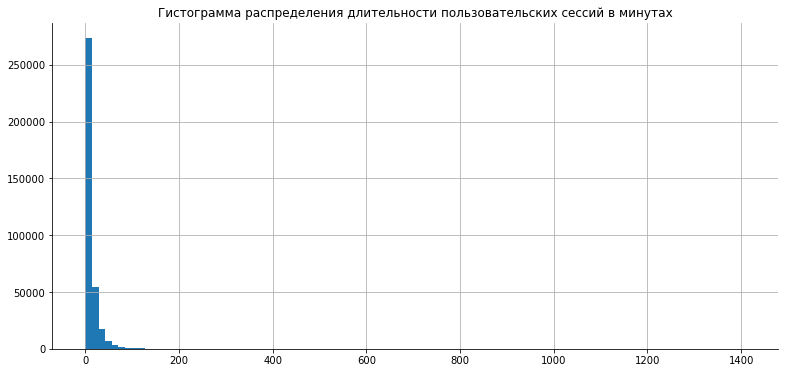

In [46]:
plt.figure(figsize=(13,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Гистограмма распределения длительности пользовательских сессий \
в минутах')
visits['asl_min'].hist(bins=100);

Распределение длительности пользовательских сессий сильно скошено вправо и большинство из значений находится близко к нулю. Для описания типичного значения лучше выбрать моду:

In [47]:
# среднее значение длительности пользовательской сессии:
print('Среднее значение длительности пользовательской сессии в минутах: {}'
      .format(visits['asl_min'].mode()[0]))

Среднее значение длительности пользовательской сессии в минутах: 1.0


Промежуток времени в одну минуту кажется очень маленьким чтобы успеть совершить покупку.

In [48]:
visits['asl_min'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: asl_min, dtype: float64

Нулевые значения длительности это странно. Посмотрим, сколько таких значений.

In [49]:
visits[visits['asl']==0].head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,asl,asl_min
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,0.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,0.0
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957,2017,11,45,2017-11-09,0,0.0
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510,2017,11,48,2017-11-30,0,0.0
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332,2018,2,8,2018-02-23,0,0.0


In [50]:
print('Количество визитов с совпадающим временем начала и окончания сессии: \
{:.2f}%'.format((visits[visits['asl']==0].shape[0]/visits.shape[0])*100))

Количество визитов с совпадающим временем начала и окончания сессии: 9.96%


Значений нулевой длительности сессий чуть меньше 10% от всего количества визитов. Поскольку в рамках проекта невозможно выяснить, вызвано это техническими проблемами со сбором данных или это просто случайные клики или неудавшиеся попытки пользователей войти в приложение, исключим такие визиты.

In [51]:
visits_wo_0asl = visits[visits['asl']!=0]

In [52]:
visits_wo_0asl['asl_min'].describe()

count    323606.000000
mean         11.911410
std          17.450880
min           0.316667
25%           2.000000
50%           6.000000
75%          15.000000
max        1408.000000
Name: asl_min, dtype: float64

In [53]:
print('Среднее значение длительности пользовательской сессии в минутах: {}'
      .format(visits_wo_0asl['asl_min'].mode()[0]))

Среднее значение длительности пользовательской сессии в минутах: 1.0


Удаление нулевых значений не повляило на значение типичной длительности пользовательской сессии. Возможно, большинство пользователей, посещающих сервис, действительно проводят на нем около минуты.  

**Retention Rate**

Определим, как часто люди возвращаются к приложению. Для этого рассчитаем Retention Rate  по разным когортам клиентов.  
Делить пользователей на когорты будем в зависимости от того, в каком месяце они совершили первый визит.

In [54]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'

visits = visits.join(first_activity_date, on='uid')

visits['first_activity_month'] = visits['first_activity_date'].astype(
    'datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

# рассчитываем возраст когорт
visits['lifetime'] = (visits['activity_month'] - visits[
    'first_activity_month'])/np.timedelta64(1,'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [55]:
cohorts = visits.groupby(['first_activity_month', 'lifetime']).agg(
{'uid':'nunique'}).reset_index()
cohorts = cohorts.rename(columns={'uid':'n_users'})
cohorts.head()

,first_activity_month,lifetime,n_users
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [56]:
# исходное число пользователей в когорте - число пользователей на
# "нулевой месяц жизни":
initial_users_count = cohorts[cohorts['lifetime'] == 0][[
    'first_activity_month', 'n_users']]
initial_users_count = initial_users_count.rename(columns={
    'n_users':'init_n_users'})

In [57]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

In [58]:
# рассчитываем retention_rate:
cohorts['retention'] = cohorts['n_users']/cohorts['init_n_users']
cohorts.head()

,first_activity_month,lifetime,n_users,init_n_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [59]:
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime(
'%Y-%m')

In [60]:
retention_pivot = cohorts.pivot_table(index = 'first_activity_month',
                                     columns = 'lifetime',
                                     values = 'retention',
                                     aggfunc='sum')

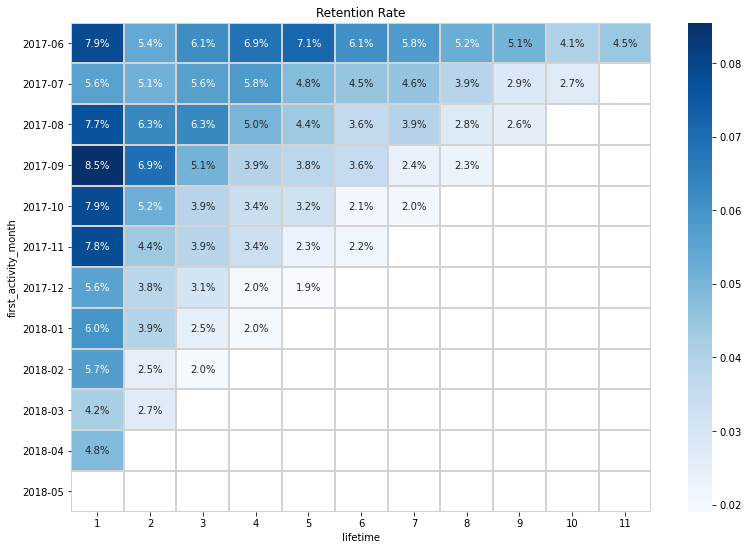

In [61]:
plt.figure(figsize=(13,9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot.iloc[:,1:], annot=True, cmap='Blues', linewidth=1,
            linecolor='lightgray', fmt='.1%');

In [62]:
print('Средний по когортам показатель возврата пользователей на следующий \
после первой покупки месяц: {:.2%}'.format(retention_pivot.iloc[:,1].mean()))

Средний по когортам показатель возврата пользователей на следующий после первой покупки месяц: 6.52%


Самый высокий показатель Retention Rate на второй месяц после покупки у сентябрьской когорты.  
У всех когорт происходит снижение Retention Rate к апрелю и маю.  
Июльская выделяется среди летних когорт сравнительно низкими показателями.  
В целом, кажется, все-таки присутствует сезонность, и с августа по октябрь-ноябрь были приняты некие маркетинговые меры.  

## Продажи

Выясним, когда люди начинают покупать

In [63]:
# выясним, когда каждым пользователем была совершена первая покупка 
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date = pd.merge(first_order_date, first_activity_date, on='uid')
first_order_date = first_order_date.rename(columns={
    'buy_ts':'first_order_date'})

In [64]:
first_order_date.head()

,first_order_date,first_activity_date
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [65]:
# рассчитывем разницу между датой первой покупки и датой первого визита
diff = first_order_date['first_order_date'] - \
first_order_date['first_activity_date']

In [66]:
# разница в днях
diff_in_days = (diff/np.timedelta64(1,'D')).round().astype('int')

In [67]:
# в часах
diff_in_hours = (diff/np.timedelta64(1,'h')).round().astype('int')

In [68]:
# в минутах
diff_in_minutes = (diff/np.timedelta64(1,'m')).round().astype('int')

Построим гистограммы распределения времени приема решения о покупке

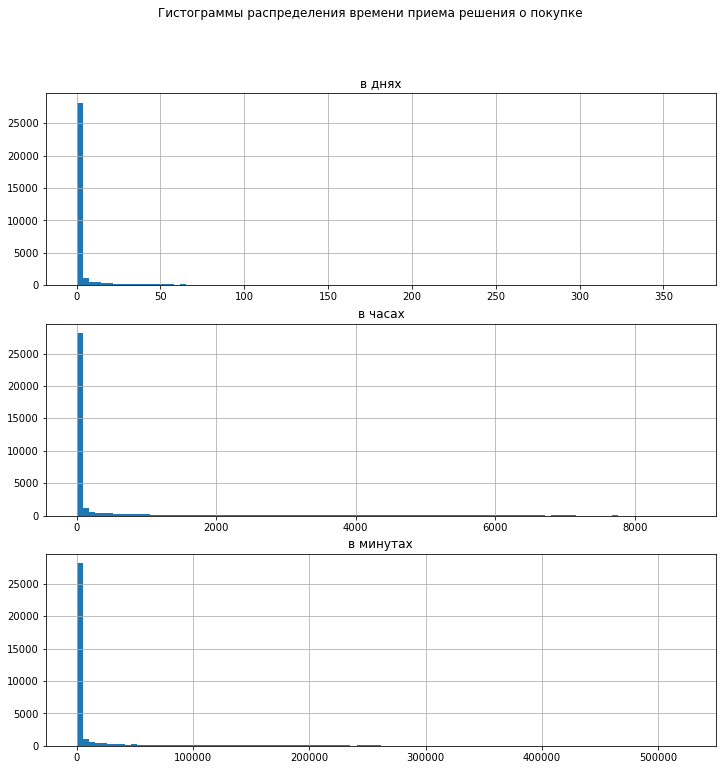

In [69]:
fig, axes = plt.subplots(3,1, figsize=(12, 12))
fig.suptitle('Гистограммы распределения времени приема решения о покупке')
diff_in_days.hist(bins=100, ax=axes[0])
diff_in_hours.hist(bins=100, ax=axes[1])
diff_in_minutes.hist(bins=100, ax=axes[2])
axes[0].set_title('в днях')
axes[1].set_title('в часах')
axes[2].set_title('в минутах');

Распределения сильно скошены вправо.  
В любом случае типичное значение находится в районе нуля.  
Определим его как моду.  

In [70]:
print('Типичное время принятия решения о покупке - {} мин.'.format(
    int(round(diff_in_minutes.mode()))))

Типичное время принятия решения о покупке - 1 мин.


In [71]:
diff_in_minutes.describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
dtype: float64

Самое распространенное значение - одна минута. Видимо, люди заходят на сайт уже зная, чего они хотят и минуты для покупки достаточно, либо, возможно, есть какая-то неточность в данных.
В среднем людям неободимо для первой покупки несколько минут, хотя у распределения времени принятия решения очень длинный хвост: есть достаточно большое количество пользователей, которым для покупки требуются месяцы знакомства с сервисом.

Выясним, сколько раз люди покупают за период.  
Добавим в таблицу год, месяц, неделю и день покупки.  

In [72]:
orders['buy_year'] = orders['buy_ts'].dt.year
orders['buy_month'] = orders['buy_ts'].dt.month
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_day'] = orders['buy_ts'].dt.date

In [73]:
# в ходе построения графиков выяснилось, что в данных о заказах есть
# одна продажа за июль 2018 года, ее лучше удалить
orders = orders[orders['buy_ts']<'2018-06-01']

In [74]:
daily_purchases = orders.groupby('buy_day').agg({'uid':'count'})
avg_daily_purchases = int(round(daily_purchases.mean()))
print('Среднее количество покупок в день: {}'.format(avg_daily_purchases))

Среднее количество покупок в день: 139


In [75]:
weekly_purchases = orders.groupby(['buy_year', 'buy_week']).agg({
    'uid':'count'})
avg_weekly_purchases = int(round(weekly_purchases.mean()))
print('Среднее количество покупок в неделю: {}'.format(avg_weekly_purchases))

Среднее количество покупок в неделю: 951


In [76]:
monthly_purchases = orders.groupby(['buy_year', 'buy_month']).agg({
    'uid':'count'})
avg_monthly_purchases = int(round(monthly_purchases.mean()))
print('Среднее количество покупок в месяц: {}'.format(avg_monthly_purchases))

Среднее количество покупок в месяц: 4201


Построим графики изменения количества покупок по времени

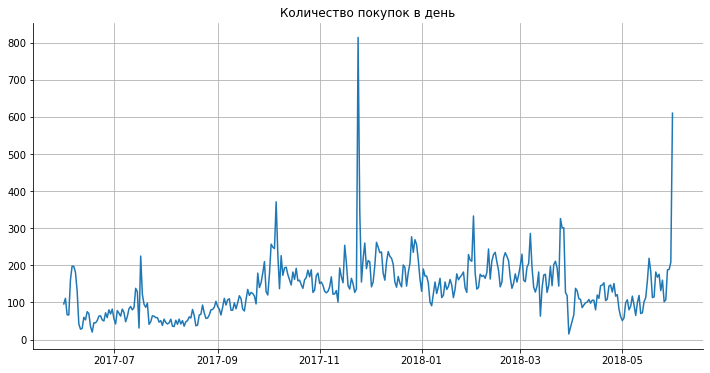

In [77]:
plt.figure(figsize=(12,6))
plt.plot(daily_purchases)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.title('Количество покупок в день');

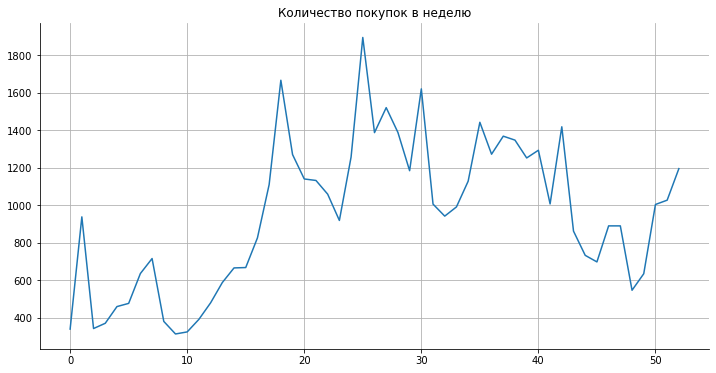

In [78]:
plt.figure(figsize=(12,6))
plt.plot(weekly_purchases.reset_index()['uid'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.title('Количество покупок в неделю');

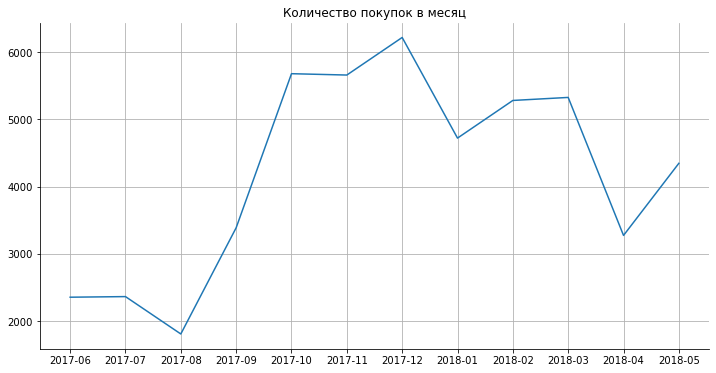

In [79]:
plt.figure(figsize=(12,6))
plt.plot(months, monthly_purchases.reset_index()['uid'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.title('Количество покупок в месяц');

Максимум количества покупок приходится на декабрь, в то время как максимальное количество визитов наблюдалось в ноябре.  

Рассмотрим количество покупок в месяц в разрезах устройств и источников привлечения. 
Будем считать, что на факт покупки пользователем повлиял первый источник привлечения и что покупка была совершена с первого использованного в день покупки устройства.  

Дополним таблицу orders необходимой информацией

In [80]:
# преобразование переменных для целей объединения
visits['session_day'] = visits['session_day'].astype('str')
orders['buy_day'] = orders['buy_day'].astype('str')

In [81]:
# информация об устройстве
first_devices = visits.groupby(['uid', 'session_day']).agg(
    {'device':'first'}).reset_index()

In [82]:
orders = orders.merge(
    first_devices, left_on=['uid', 'buy_day'], right_on=['uid','session_day'])

In [83]:
orders_desktop = orders[orders['device']=='desktop']
orders_touch = orders[orders['device']=='touch']
monthly_purchases_desktop = orders_desktop.groupby([
    'buy_year', 'buy_month']).agg({'uid':'count'})
monthly_purchases_touch = orders_touch.groupby(['buy_year', 'buy_month']).agg(
{'uid':'count'})

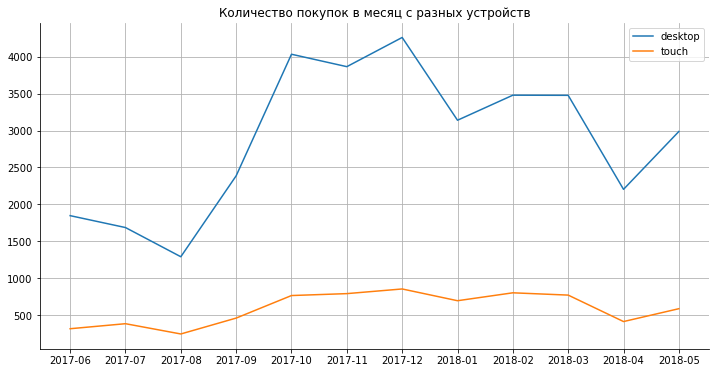

In [84]:
plt.figure(figsize=(12,6))
plt.plot(months, monthly_purchases_desktop.reset_index()['uid'],
         label='desktop')
plt.plot(months, monthly_purchases_touch.reset_index()['uid'], label='touch')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.grid()
plt.title('Количество покупок в месяц с разных устройств');

Как и в случае с визитами, с планшета покупают более стабильно и гораздо меньше.

In [85]:
# информация об источнике привлечения
first_sources = visits.sort_values(by='start_ts').groupby(['uid']).agg(
    {'source_id':'first'})

In [86]:
orders = orders.join(first_sources, on='uid')

В ходе построения графиков выяснилось, что из источника 7 была совершена только одна покупка в августе 2018 года, так что мы его далее рассматривать не будем.

In [87]:
orders[orders['source_id']==7].groupby([
        'buy_year', 'buy_month']).agg({'uid':'nunique'}).reset_index()

,buy_year,buy_month,uid
0,2017,8,1


In [88]:
orders = orders[orders['source_id']!=7]

In [89]:
sources = orders['source_id'].unique()

In [90]:
def plot_orders_by_source(s_id):
    plt.plot(months,
        orders[orders['source_id']==s_id].groupby([
        'buy_year', 'buy_month']).agg({'uid':'nunique'}).reset_index()[
            'uid'],label=s_id)

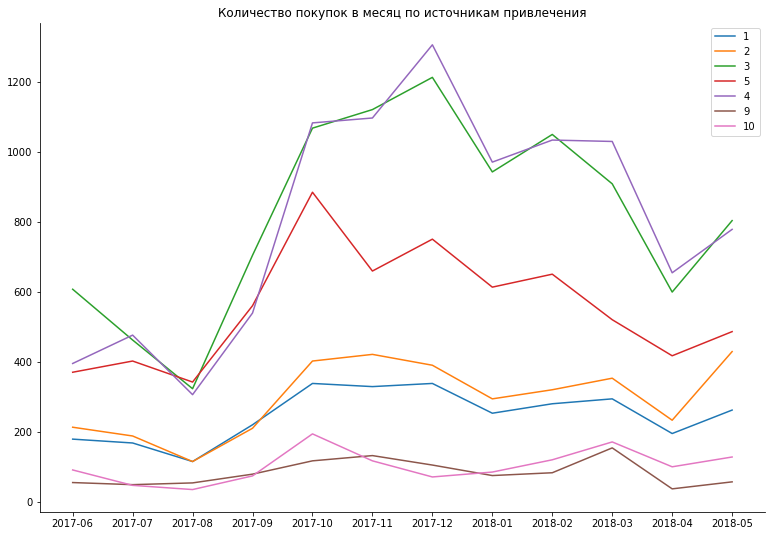

In [91]:
plt.figure(figsize=(13,9))
for source in sources:
    plot_orders_by_source(source)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Количество покупок в месяц по источникам привлечения');

Судя по графику, наиболее действенные источники привлечения - 4, 3 и 5, что согласуется с выводами, сделанными после анализа количества визитов.  
И именно эти источники обеспечивали значительный рост продаж с августа по декабрь 2017 года.

In [92]:
orders_by_users = orders.groupby('buy_day').agg({'uid':['count', 'nunique']})
orders_by_users.columns = ['n_orders', 'n_users']
orders_by_users['orders_per_user'] = orders_by_users['n_orders']/\
orders_by_users['n_users']
orders_by_users.head()

,n_orders,n_users,orders_per_user
buy_day,,,
2017-06-01,96,86,1.116279
2017-06-02,108,98,1.102041
2017-06-03,64,59,1.084746
2017-06-04,60,53,1.132075
2017-06-05,154,139,1.107914


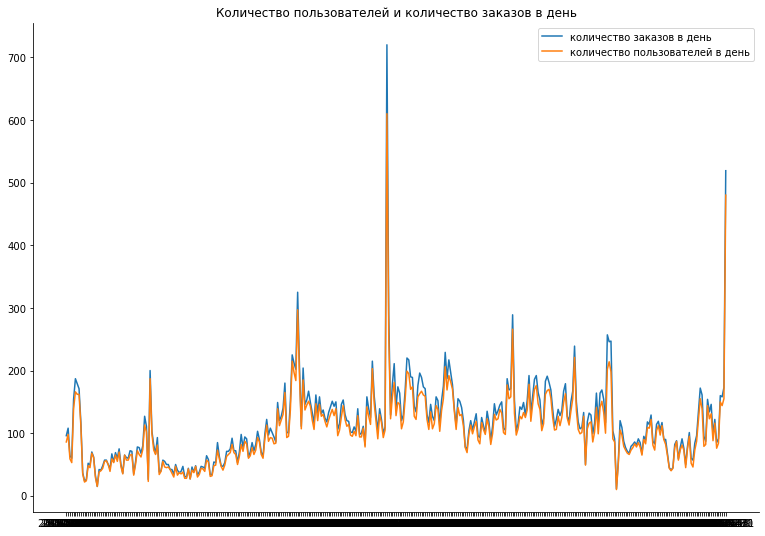

In [93]:
plt.figure(figsize=(13,9))
plt.title('Количество пользователей и количество заказов в день')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(orders_by_users['n_orders'], label='количество заказов в день')
plt.plot(orders_by_users['n_users'], label='количество пользователей в день')
plt.legend();

По графику видно, что на пользователя приходится около одного заказа.

In [94]:
avg_orders_per_user = orders_by_users['orders_per_user'].mean()
avg_orders_per_user

1.0890645206058245

In [95]:
print('Среднее число заказов, которе совершает пользователь: {:.0f}.'
      .format(avg_orders_per_user))

Среднее число заказов, которе совершает пользователь: 1.


**Рассчитаем средний чек**

Рассчитывать средний чек будем по когортам. Когорта - пользователи, совершивышие первый заказ в определенном месяце. 

In [96]:
first_order_date.head()

,first_order_date,first_activity_date
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [97]:
orders = orders.join(first_order_date['first_order_date'], on='uid')

In [98]:
orders['first_order_month'] = orders['first_order_date'].astype(
    'datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [99]:
orders_by_cohorts = orders.groupby(['first_order_month', 'order_month']).agg(
{'revenue':'sum', 'uid':'count'}).reset_index()
orders_by_cohorts = orders_by_cohorts.rename(columns={
    'revenue':'total_revenue', 'uid':'n_orders'})
orders_by_cohorts.head()

,first_order_month,order_month,total_revenue,n_orders
0,2017-06-01,2017-06-01,8636.07,2166
1,2017-06-01,2017-07-01,714.79,121
2,2017-06-01,2017-08-01,633.93,124
3,2017-06-01,2017-09-01,1578.26,177
4,2017-06-01,2017-10-01,1476.68,222


In [100]:
orders_by_cohorts['revenue_per_order'] = orders_by_cohorts['total_revenue']/\
orders_by_cohorts['n_orders']
orders_by_cohorts.head()

,first_order_month,order_month,total_revenue,n_orders,revenue_per_order
0,2017-06-01,2017-06-01,8636.07,2166,3.987105
1,2017-06-01,2017-07-01,714.79,121,5.907355
2,2017-06-01,2017-08-01,633.93,124,5.112339
3,2017-06-01,2017-09-01,1578.26,177,8.916723
4,2017-06-01,2017-10-01,1476.68,222,6.651712


In [101]:
# найдем "возраст" когорты - lifetime (для дальнейших расчетов)
orders_by_cohorts['lifetime'] = (orders_by_cohorts['order_month']\
- orders_by_cohorts['first_order_month'])/np.timedelta64(1, 'M')
orders_by_cohorts['lifetime'] = orders_by_cohorts['lifetime'].round(
).astype('int')

In [102]:
print('Средний чек за весь рассматриваемый период: {:.2f}'.format(
    orders_by_cohorts['total_revenue'].sum()/orders_by_cohorts[
        'n_orders'].sum()))

Средний чек за весь рассматриваемый период: 4.88


In [103]:
print(orders.revenue.sum()/orders.shape[0])

4.882717976963051


In [104]:
orders_by_cohorts['first_order_month'] = orders_by_cohorts[
    'first_order_month'].dt.strftime('%Y-%m')
orders_by_cohorts['order_month'] = orders_by_cohorts[
    'order_month'].dt.strftime('%Y-%m')

In [105]:
revenue_per_order_pivot = orders_by_cohorts.pivot_table(
index='first_order_month', 
columns='order_month',
values='revenue_per_order',
aggfunc='mean')

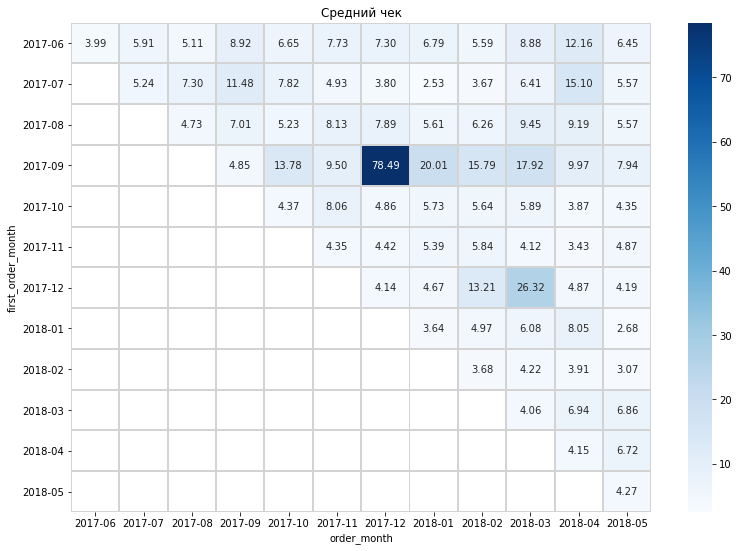

In [106]:
plt.figure(figsize=(13,9))
plt.title('Средний чек')
sns.heatmap(revenue_per_order_pivot, annot=True, cmap='Blues', linewidth=1,
            linecolor='lightgray', fmt='.2f');

По тепловой карте сложно отследить какую-либо тенденцию.  
Резко выделяется средний чек сентябрьской когорты в декабре.

In [107]:
# посмотрим на этот период подробнее
orders_dec_sep_cohort = orders[(orders['buy_month']==12)&(orders[
    'first_order_month']=='2017-09-01')]

In [108]:
orders_dec_sep_cohort['revenue'].describe()

count     117.000000
mean       78.485897
std       274.154244
min         0.030000
25%         1.830000
50%         9.900000
75%        48.280000
max      2633.280000
Name: revenue, dtype: float64

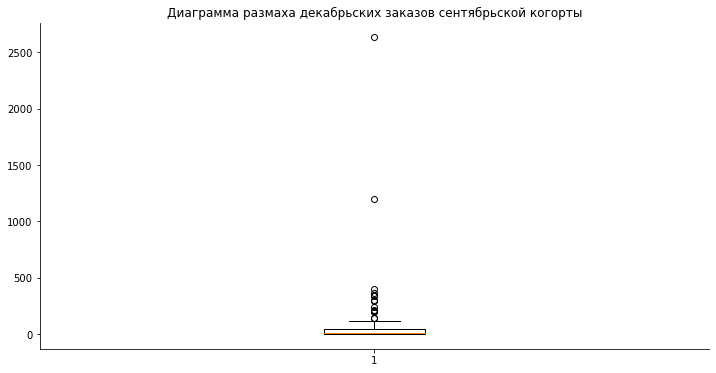

In [109]:
plt.figure(figsize=(12,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.boxplot(orders_dec_sep_cohort['revenue'])
plt.title('Диаграмма размаха декабрьских заказов сентябрьской когорты');

In [110]:
orders['revenue'].describe()

count    41759.000000
mean         4.882718
std         20.674938
min          0.000000
25%          1.220000
50%          2.440000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [111]:
# источники, обеспечившие самые дорогие заказы
orders[orders['revenue']>=500]['source_id'].unique()

array([3, 5, 2])

In [112]:
orders_dec_sep_cohort_wo_outliers = orders_dec_sep_cohort[
    orders_dec_sep_cohort['revenue']<=500]

In [113]:
orders_dec_sep_cohort_wo_outliers['revenue'].mean()

46.55591304347826

In [114]:
orders_dec_sep_cohort_wo_outliers['revenue'].describe()

count    115.000000
mean      46.555913
std       85.140353
min        0.030000
25%        1.770000
50%        9.470000
75%       45.370000
max      402.720000
Name: revenue, dtype: float64

Аномально высокое значение доходов в декабре обеспечили несколько дорогих заказов. 

Рассчитаем средний чек по источникам привлечения.

In [115]:
def create_revenue_per_order_pivot(s_id):
    df = orders[orders['source_id']==s_id]
    
    df_by_cohorts = df.groupby(['first_order_month', 'order_month']).agg(
        {'revenue':'sum', 'uid':'count'}).reset_index()
    df_by_cohorts = df_by_cohorts.rename(columns={'revenue':'total_revenue',
                                              'uid':'n_orders'})
    df_by_cohorts['revenue_per_order'] = df_by_cohorts['total_revenue']/\
    df_by_cohorts['n_orders']
    
    df_by_cohorts['first_order_month'] = df_by_cohorts[
        'first_order_month'].dt.strftime(
        '%Y-%m')
    df_by_cohorts['order_month'] = df_by_cohorts['order_month'].dt.strftime(
        '%Y-%m')
    
    print('Средний чек за весь рассматриваемый период для источника {}: {:.2f}'
          .format(s_id, df_by_cohorts['total_revenue'].sum()/df_by_cohorts[
              'n_orders'].sum()))
    
    revenue_per_order_pivot = df_by_cohorts.pivot_table(
    index='first_order_month', 
    columns='order_month',
    values='revenue_per_order',
    aggfunc='mean')
    
    return revenue_per_order_pivot  

In [116]:
orders['source_id'].unique()

array([ 1,  2,  3,  5,  4,  9, 10])

Средний чек за весь рассматриваемый период для источника 1: 5.87
Средний чек за весь рассматриваемый период для источника 2: 6.61
Средний чек за весь рассматриваемый период для источника 3: 4.08
Средний чек за весь рассматриваемый период для источника 5: 5.60
Средний чек за весь рассматриваемый период для источника 4: 4.34
Средний чек за весь рассматриваемый период для источника 9: 3.43
Средний чек за весь рассматриваемый период для источника 10: 2.81


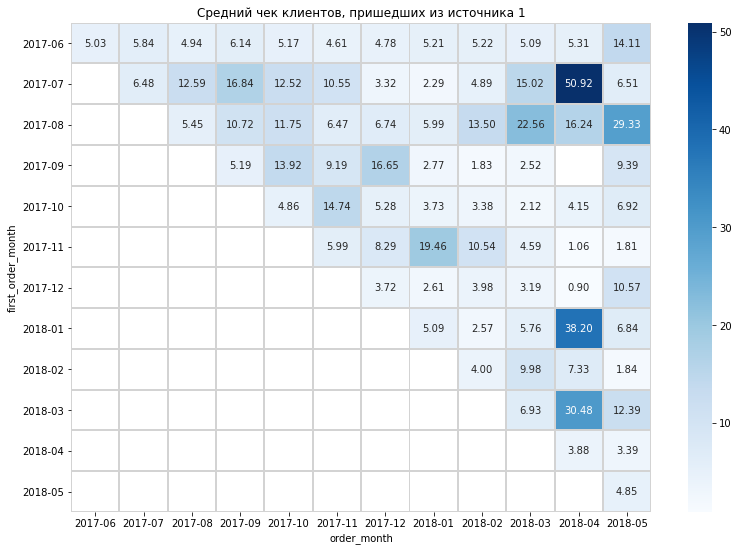

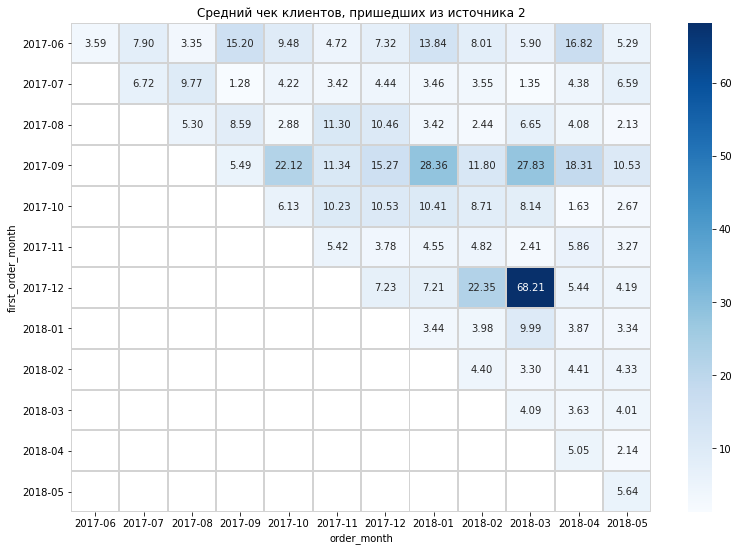

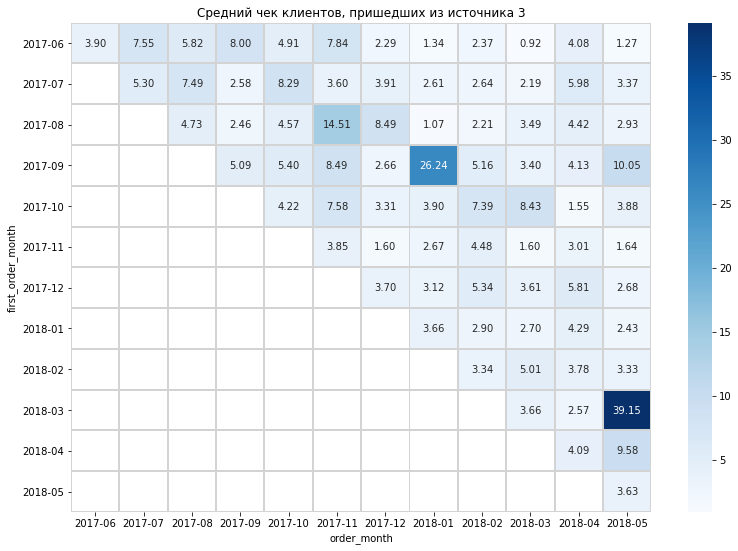

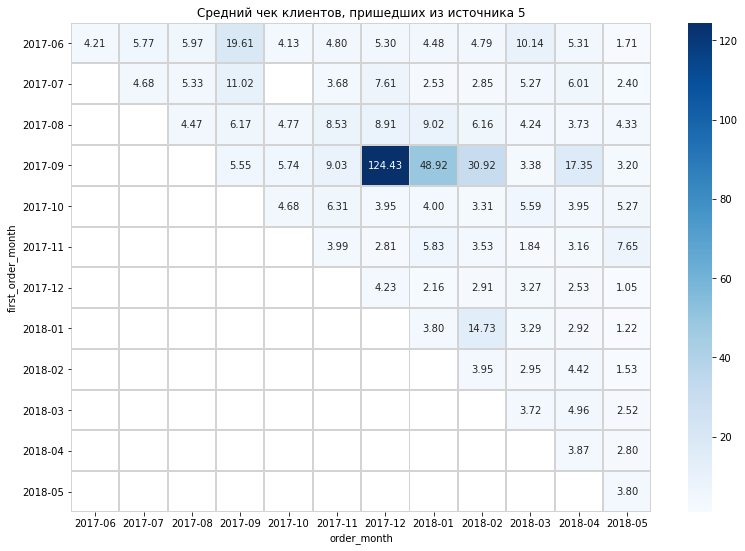

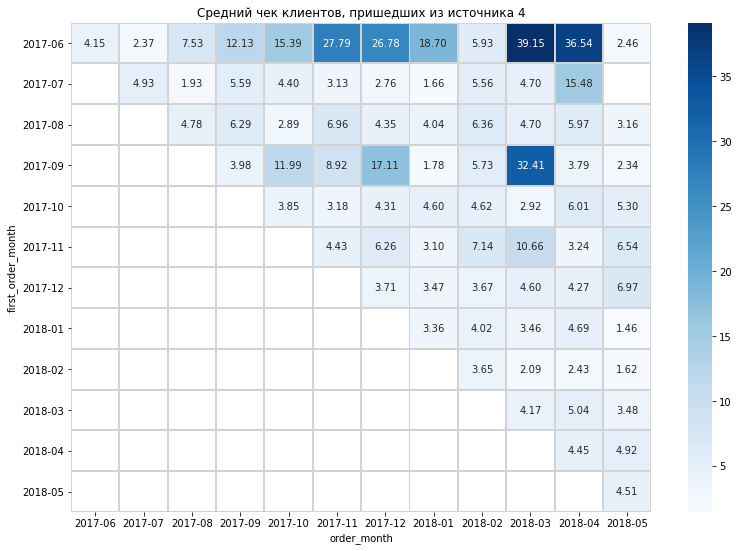

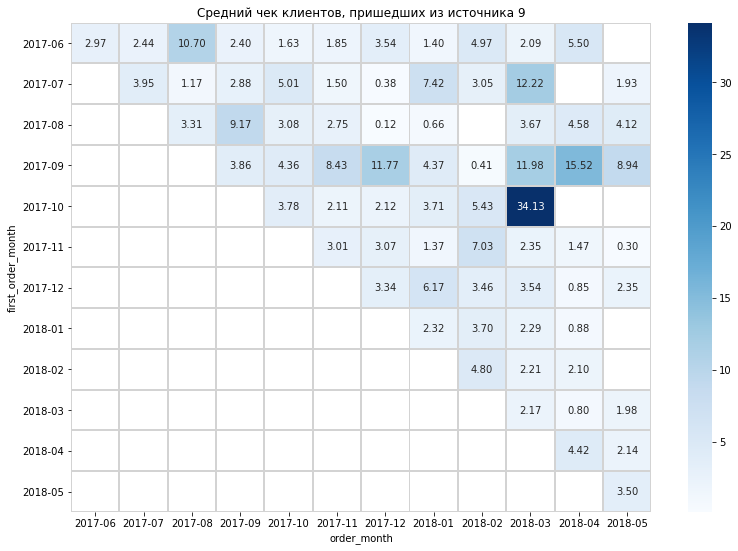

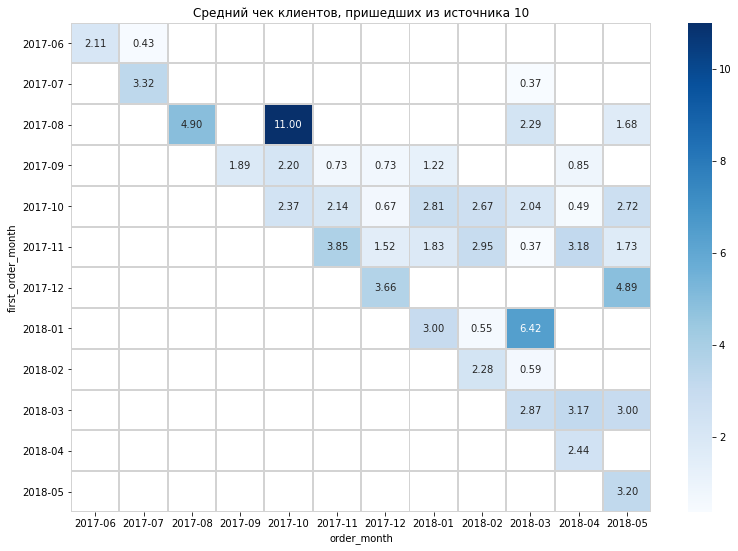

In [117]:
for source in sources:
    pivot = create_revenue_per_order_pivot(source)
    plt.figure(figsize=(13,9))
    plt.title('Средний чек клиентов, пришедших из источника {}'.format(source))
    sns.heatmap(pivot, annot=True, cmap='Blues', linewidth=1,
               linecolor='lightgray', fmt='.2f');

Самое большое значение среднего чека у пользователей, пришедших из второго источника.  
Средние чеки достигают своего макисмума в разные периоды.  
В целом, по этому показателю можно выделить как наиболее перспективные источники 2,1 и 5.  

**LTV**

В рамках данного проекта нет возможности учесть маржинальность, поэтому LTV будем рассчитывать по выручке, а не по валовой прибыли.  
LTV будем рассчитывать за полгода. 

In [118]:
orders['buy_ts'].describe()

count                   41759
unique                  38663
top       2017-11-24 17:42:00
freq                        7
first     2017-06-01 00:10:00
last      2018-05-31 23:54:00
Name: buy_ts, dtype: object

In [119]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Данные по заказам и по расходам предоставлены за один и тот же промежуток времени - с начала июня по конец мая.

In [120]:
orders.head()

,buy_ts,revenue,uid,buy_year,buy_month,buy_week,buy_day,session_day,device,source_id,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6,22,2017-06-01,2017-06-01,desktop,1,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6,22,2017-06-01,2017-06-01,desktop,2,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,6,22,2017-06-01,2017-06-01,desktop,2,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,6,22,2017-06-01,2017-06-01,desktop,2,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,6,22,2017-06-01,2017-06-01,desktop,3,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [121]:
orders_by_cohorts.head()

,first_order_month,order_month,total_revenue,n_orders,revenue_per_order,lifetime
0,2017-06,2017-06,8636.07,2166,3.987105,0
1,2017-06,2017-07,714.79,121,5.907355,1
2,2017-06,2017-08,633.93,124,5.112339,2
3,2017-06,2017-09,1578.26,177,8.916723,3
4,2017-06,2017-10,1476.68,222,6.651712,4


In [122]:
first_order_date = first_order_date.reset_index()

In [123]:
first_order_date['first_order_month'] = first_order_date[
    'first_order_date'].astype('datetime64[M]')

In [124]:
# добавим в таблицу first_order_date информацию об источнике
# привлечения ользователя
first_order_date = first_order_date.join(first_sources, on='uid')

In [125]:
first_order_date.head()

,uid,first_order_date,first_activity_date,first_order_month,source_id
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2018-01-01,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-01,10
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,2017-10-01,3
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2018-01-01,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-01,5


In [126]:
# находим количество пользователей в каждой когорте
cohort_sizes = first_order_date.groupby('first_order_month').agg(
{'uid':'nunique'}).reset_index()
cohort_sizes['first_order_month'] = cohort_sizes[
    'first_order_month'].dt.strftime('%Y-%m')
cohort_sizes = cohort_sizes.rename(columns={'uid':'n_buyers_in_cohort'})
cohort_sizes.head()

,first_order_month,n_buyers_in_cohort
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340


In [127]:
orders_by_cohorts = orders_by_cohorts.merge(
    cohort_sizes, on='first_order_month')

In [128]:
orders_by_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_order_month   78 non-null     object 
 1   order_month         78 non-null     object 
 2   total_revenue       78 non-null     float64
 3   n_orders            78 non-null     int64  
 4   revenue_per_order   78 non-null     float64
 5   lifetime            78 non-null     int64  
 6   n_buyers_in_cohort  78 non-null     int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 4.9+ KB


Находим LTV: разделим выручку когорт за каждый месяц на общее число пользователей в каждой когорте. 

In [129]:
orders_by_cohorts['ltv'] = orders_by_cohorts[
    'total_revenue']/orders_by_cohorts['n_buyers_in_cohort']

In [130]:
ltv_pivot = orders_by_cohorts.pivot_table(
index = 'first_order_month',
columns = 'lifetime',
values = 'ltv', 
aggfunc='mean')

In [131]:
ltv_pivot = ltv_pivot.cumsum(axis=1).round(2)
ltv_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.27,4.62,4.94,5.72,6.45,7.04,7.86,8.31,8.75,9.20,9.59,9.78
2017-07,5.32,5.56,6.06,6.31,6.43,6.55,6.60,6.65,6.77,6.90,7.01,NaN
2017-08,4.67,5.03,5.28,5.56,5.89,6.05,6.19,6.51,6.73,6.88,NaN,NaN
2017-09,4.73,5.54,5.89,9.45,9.77,10.20,10.63,10.76,10.88,NaN,NaN,NaN
2017-10,4.33,4.69,4.81,4.89,4.98,5.07,5.12,5.21,NaN,NaN,NaN,NaN
2017-11,4.39,4.69,4.85,5.07,5.15,5.18,5.26,NaN,NaN,NaN,NaN,NaN
2017-12,4.03,4.23,4.65,5.33,5.40,5.47,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3.46,3.71,3.91,4.03,4.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,3.50,3.67,3.72,3.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
ltv = ltv_pivot.iloc[:7,5]
ltv

first_order_month
2017-06     7.04
2017-07     6.55
2017-08     6.05
2017-09    10.20
2017-10     5.07
2017-11     5.18
2017-12     5.47
Name: 5, dtype: float64

Примем за время жизни пользователя 6 месяцев и будем сравнивать этот показатель только у тех когорт, которые "прожили" такое время, то есть 2017-06 - 2017-12.  
Самой прибыльной оказалась сентябрьская когорта, и, как мы помним из анализа среднего чека, в декабре пользователями сентябрьской когорты были сделаны несколько крупных заказов.  
Наименее прибыльны октябрьская и ноябрьская когорты.

Рассчитаем LTV по источникам привлечения.

In [133]:
def create_ltv_pivot(s_id):
    first_order = first_order_date[first_order_date['source_id']==s_id]
    
    cohort_sizes = first_order.groupby('first_order_month').agg(
        {'uid':'nunique'}).reset_index()
    #cohort_sizes['first_order_month'] = cohort_sizes[
    #    'first_order_month'].dt.strftime('%Y-%m')
    cohort_sizes = cohort_sizes.rename(columns={'uid':'n_buyers_in_cohort'})
    
    df = orders[orders['source_id']==s_id]
    
    df_by_cohorts = df.groupby(['first_order_month', 'order_month']).agg(
        {'revenue':'sum', 'uid':'nunique'}).reset_index()
    df_by_cohorts = df_by_cohorts.rename(columns={'revenue':'total_revenue',
                                              'uid':'n_un_users'})
    
    df_by_cohorts = df_by_cohorts.merge(cohort_sizes, on='first_order_month')
    
    df_by_cohorts['lifetime'] = (df_by_cohorts['order_month']\
    - df_by_cohorts['first_order_month'])/np.timedelta64(1, 'M')
    df_by_cohorts['lifetime'] = df_by_cohorts['lifetime'].round().astype('int')
    
    df_by_cohorts['first_order_month'] = df_by_cohorts[
        'first_order_month'].dt.strftime('%Y-%m')
    df_by_cohorts['order_month'] = df_by_cohorts['order_month'].dt.strftime(
        '%Y-%m')
    
    df_by_cohorts['ltv'] = df_by_cohorts['total_revenue']/df_by_cohorts[
    'n_buyers_in_cohort']
    
    ltv_pivot = df_by_cohorts.pivot_table(
    index = 'first_order_month',
    columns = 'lifetime',
    values = 'ltv', 
    aggfunc='mean')
    
    ltv_pivot = ltv_pivot.cumsum(axis=1).round(2)
    
    return ltv_pivot

In [134]:
ltv_table = pd.DataFrame(index=ltv.index, columns=sources)

In [135]:
for source in sources:
    pivot = create_ltv_pivot(source)
    ltv_slice = pivot.iloc[:7,5]
    ltv_table[source] = ltv_slice 

In [136]:
ltv_table

,1,2,3,5,4,9,10
first_order_month,,,,,,,
2017-06,17.00,8.54,4.71,7.04,6.83,3.83,NaN
2017-07,15.60,8.50,5.68,5.50,5.13,5.35,NaN
2017-08,8.79,6.68,4.95,7.41,5.10,3.55,NaN
2017-09,7.84,16.25,5.49,22.42,4.76,5.57,NaN
2017-10,6.18,9.79,4.57,5.10,4.20,4.20,2.41
2017-11,8.46,7.70,4.13,4.22,5.41,3.22,4.17
2017-12,4.66,21.16,3.88,4.45,3.75,3.39,2.90


Сравним ltv за шесть месяцев по разным источникам (столбцы таблицы)

In [137]:
avg_ltv = ltv_table.apply('mean')

In [138]:
avg_ltv

1      9.790000
2     11.231429
3      4.772857
5      8.020000
4      5.025714
9      4.158571
10     3.160000
dtype: float64

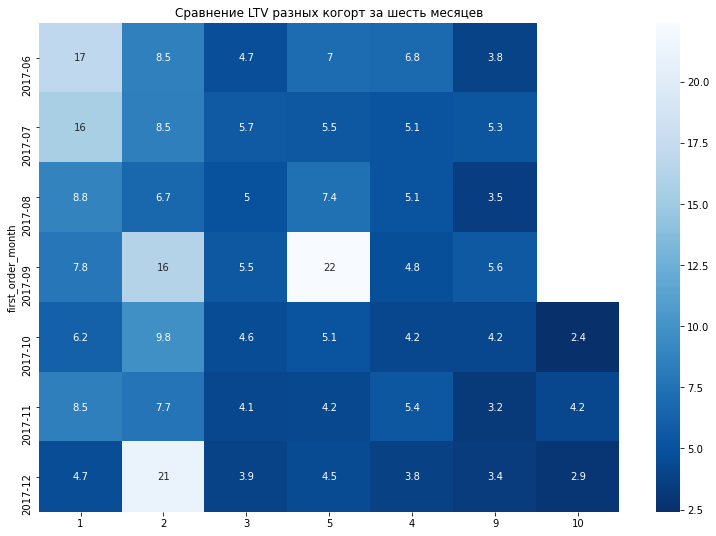

In [139]:
plt.figure(figsize = (13, 9))
plt.title('Сравнение LTV разных когорт за шесть месяцев')
sns.heatmap(ltv_table, annot=True, cmap='Blues_r');

В среднем наибольшую выручку за полгода "жизни" приносят пользователи из сентябрьской когорты, привлеченные из 5 источника и пользователи из декабрьской когорты, привлеченные из второго источника.  
Хорошие показатели были у июньской и июльской когорт, привлеченных из первого источника и у сентябрьской когорты из второго источника.  
Самым неэффективным кажется 10 источник привлечения.

## Маркетинг

Проанализируем маркетинговые расходы.

In [140]:
print('Всего на привлечение клиентов за рассматриваемый период потрачено: {}'
      .format(costs['costs'].sum()))

Всего на привлечение клиентов за рассматриваемый период потрачено: 329131.62


In [141]:
# посмотрим на общие затраты по источникам
costs_by_sources = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_sources = costs_by_sources.sort_values('costs', ascending=False)
pct_diff = costs_by_sources.pct_change()
pd.concat([costs_by_sources, pct_diff], axis=1)

,costs,costs
source_id,,
3,141321.63,NaN
4,61073.60,-0.567840
5,51757.10,-0.152545
2,42806.04,-0.172944
1,20833.27,-0.513310
10,5822.49,-0.720520
9,5517.49,-0.052383


Дороже всего обошелся третий источник - на него потрачено более чем в два раза больше, чем на следующий за ним по общим суммарным затратам четвертый.  

In [142]:
print('На самый дорогой источник привлечения потрачено {:.0%} \
от общих расходов'.format(141321.63/329131.62))

На самый дорогой источник привлечения потрачено 43% от общих расходов


Рассмотрим, как затраты были распределены во времени.

In [143]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m')

In [144]:
costs_by_months = costs.groupby('cost_month', as_index=False)['costs'].sum()
costs_by_months.head()

,cost_month,costs
0,2017-06,18015.00
1,2017-07,18240.59
2,2017-08,14790.54
3,2017-09,24368.91
4,2017-10,36322.88


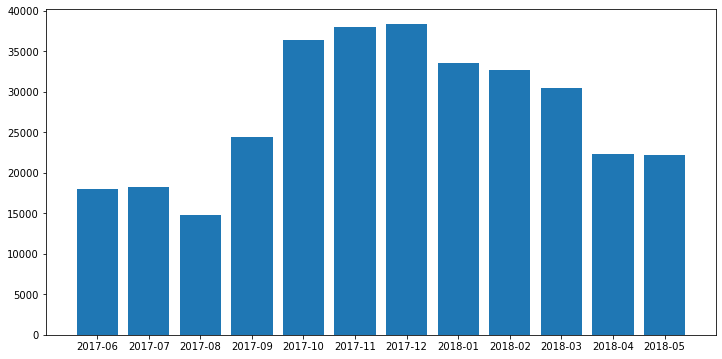

In [145]:
plt.figure(figsize=(12,6))
plt.bar(costs_by_months['cost_month'], costs_by_months['costs']);

Общие маркетинговые расхды достигают максимума в декабре.  

Посмотрим на распределение затрат во времени по каждому источнику.  

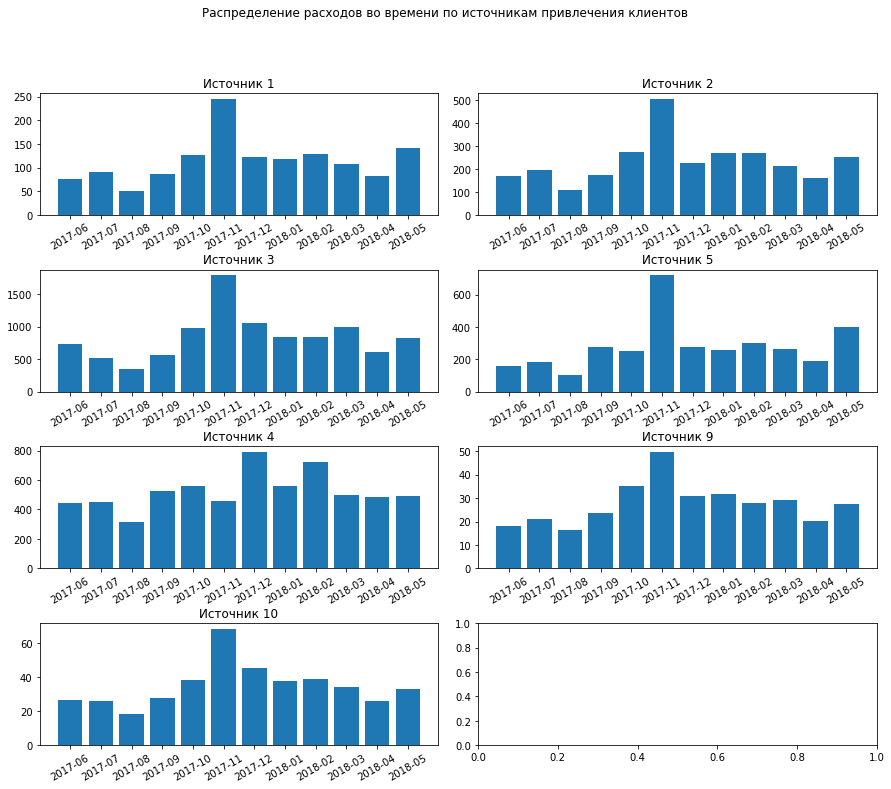

In [146]:
fig, axes = plt.subplots(4, 2, figsize=(15,12))
fig.suptitle('Распределение расходов во времени по источникам \
привлечения клиентов')
fig.subplots_adjust(wspace=0.1, hspace=0.45)
for i in range(len(sources)):
    df = costs[costs['source_id']==sources[i]]
    axes[i//2, i%2].bar(df['cost_month'], df['costs'])
    axes[i//2, i%2].set_title('Источник '+str(sources[i]))
    axes[i//2, i%2].set_xticklabels(months, rotation=30)

Практически у всех источников максимум затрат приходятся на ноябрь (только у четвертого - на декабрь), затем расходы резко снижаются.    
Возможно, пик визитов в ноябре - скорее результат неких маркетинговых кампаний, чем сезонного повышения спроса.  

Рассчитаем затраты на привлечение однго клиента по разным источникам.

In [147]:
orders_by_source = orders.groupby('source_id').agg({'uid':'nunique'})
orders_by_source

,uid
source_id,
1,2647
2,3101
3,9203
4,9077
5,6238
9,845
10,1191


In [148]:
cac_by_source = orders_by_source.merge(costs_by_sources, left_index=True,
                                       right_index=True)
cac_by_source['cac'] = cac_by_source['costs']/cac_by_source['uid']
cac_by_source = cac_by_source.reset_index()
cac_by_source = cac_by_source.rename(columns={
    'index':'source_id', 'uid':'n_users'})
cac_by_source

,source_id,n_users,costs,cac
0,1,2647,20833.27,7.870521
1,2,3101,42806.04,13.803947
2,3,9203,141321.63,15.356039
3,4,9077,61073.60,6.728390
4,5,6238,51757.10,8.297066
5,9,845,5517.49,6.529574
6,10,1191,5822.49,4.888741


Дороже всего обходится клиент, привлеченный из третьего источника. Видимо, большие затраты не приводят к достаточному количеству клиентов.

Рассчитаем окупаемость затрат по когортам:

In [149]:
cac_by_cohort = orders_by_cohorts.merge(
    costs_by_months, left_on='first_order_month', right_on='cost_month')

In [150]:
cac_by_cohort['cac'] = cac_by_cohort['costs']/cac_by_cohort[
    'n_buyers_in_cohort']

In [151]:
cac_by_cohort['romi'] = cac_by_cohort['ltv']/cac_by_cohort['cac']

In [152]:
cohort_romi_pivot = cac_by_cohort.pivot_table(index='first_order_month',
                                             columns='lifetime',
                                             values='romi',
                                             aggfunc='mean')
cohort_romi_pivot = cohort_romi_pivot.cumsum(axis=1).round(2)

In [153]:
cohort_romi_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.48,0.52,0.55,0.64,0.72,0.79,0.88,0.93,0.98,1.03,1.08,1.1
2017-07,0.56,0.59,0.64,0.67,0.68,0.69,0.7,0.7,0.71,0.73,0.74,
2017-08,0.43,0.47,0.49,0.51,0.55,0.56,0.57,0.6,0.62,0.64,,
2017-09,0.50,0.59,0.62,1,1.04,1.08,1.13,1.14,1.15,,,
2017-10,0.52,0.56,0.57,0.58,0.6,0.61,0.61,0.62,,,,
2017-11,0.47,0.5,0.52,0.55,0.55,0.56,0.57,,,,,
2017-12,0.46,0.48,0.53,0.61,0.62,0.63,,,,,,
2018-01,0.35,0.37,0.39,0.41,0.41,,,,,,,
2018-02,0.39,0.41,0.42,0.42,,,,,,,,


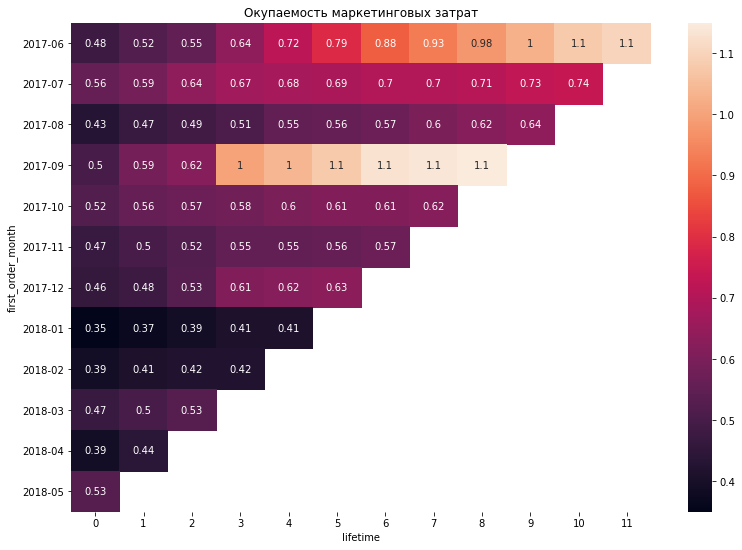

In [154]:
plt.figure(figsize=(13,9))
plt.title('Окупаемость маркетинговых затрат')
sns.heatmap(cohort_romi_pivot, annot=True);

Сентябрьская когорта окупилась на четвертый месяц "жизни", июньская - только на девятый.  Остальные когорты пока убыточны.  

Построим тепловые карты окупаемости отдельно по источникам.

In [155]:
def create_romi_pivot(s_id):
    costs_by_months_slice = costs[costs['source_id']==s_id].groupby(
        'cost_month', as_index=False)['costs'].sum()
    
    orders_slice = orders[orders['source_id']==s_id]
    
    first_order = first_order_date[first_order_date['source_id']==s_id]
    
    cohort_sizes = first_order.groupby('first_order_month').agg(
        {'uid':'nunique'}).reset_index()
  
    cohort_sizes = cohort_sizes.rename(columns={'uid':'n_buyers_in_cohort'})
    
    df_by_cohorts = orders_slice.groupby([
        'first_order_month', 'order_month']).agg(
        {'revenue':'sum', 'uid':'nunique'}).reset_index()
    df_by_cohorts = df_by_cohorts.rename(columns={'revenue':'total_revenue',
                                              'uid':'n_un_users'})
    
    df_by_cohorts = df_by_cohorts.merge(cohort_sizes, on='first_order_month')
    
    df_by_cohorts['lifetime'] = (df_by_cohorts['order_month']\
    - df_by_cohorts['first_order_month'])/np.timedelta64(1, 'M')
    df_by_cohorts['lifetime'] = df_by_cohorts['lifetime'].round().astype('int')
    
    df_by_cohorts['first_order_month'] = df_by_cohorts[
        'first_order_month'].dt.strftime('%Y-%m')
    
    cac_by_cohort = df_by_cohorts.merge(costs_by_months_slice, 
                                    left_on='first_order_month',
                                    right_on='cost_month')
    cac_by_cohort['ltv'] = cac_by_cohort['total_revenue']/cac_by_cohort[
    'n_buyers_in_cohort']
    cac_by_cohort['cac'] = cac_by_cohort['costs']/cac_by_cohort[
        'n_buyers_in_cohort']
    cac_by_cohort['romi'] = cac_by_cohort['ltv']/cac_by_cohort['cac']
    
    cohort_romi_pivot = cac_by_cohort.pivot_table(index='first_order_month',
                                             columns='lifetime',
                                             values='romi',
                                             aggfunc='mean')
    cohort_romi_pivot = cohort_romi_pivot.cumsum(axis=1).round(2)
    return cohort_romi_pivot
    
    

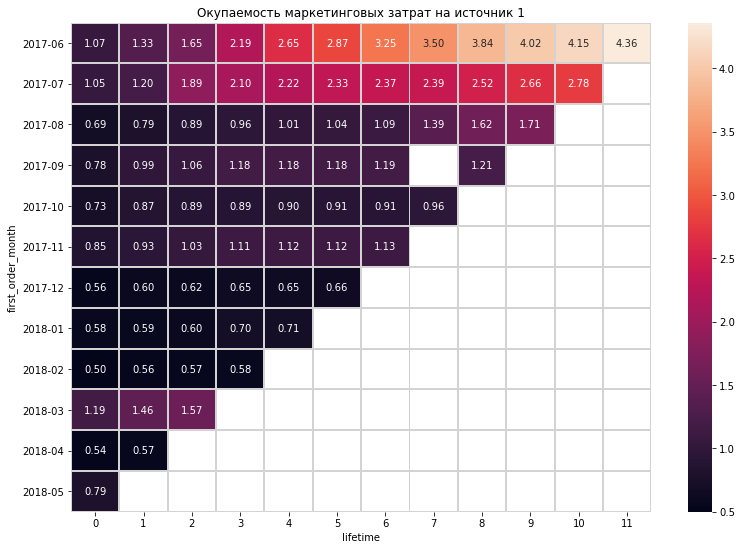

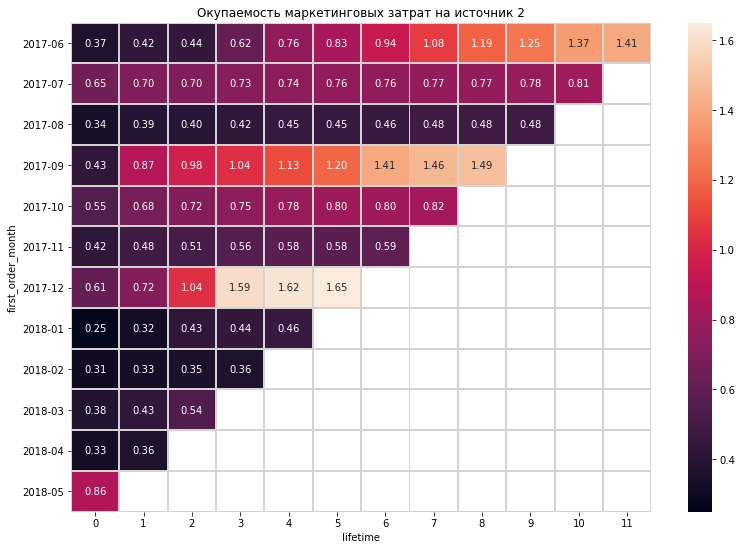

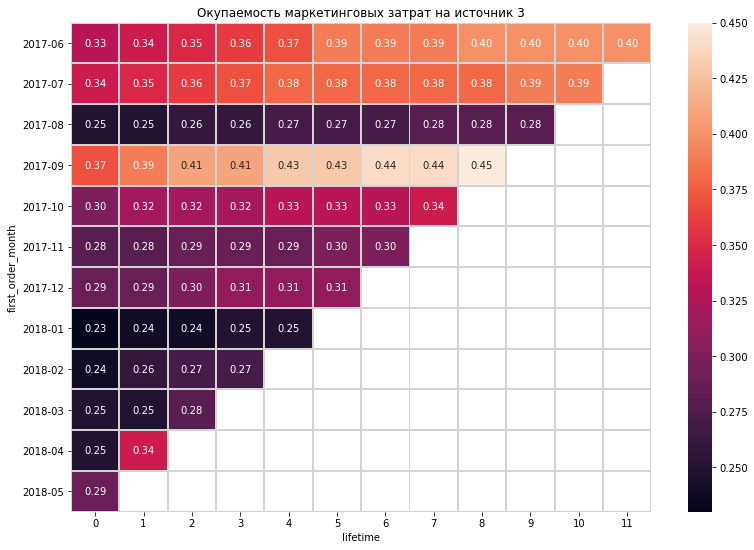

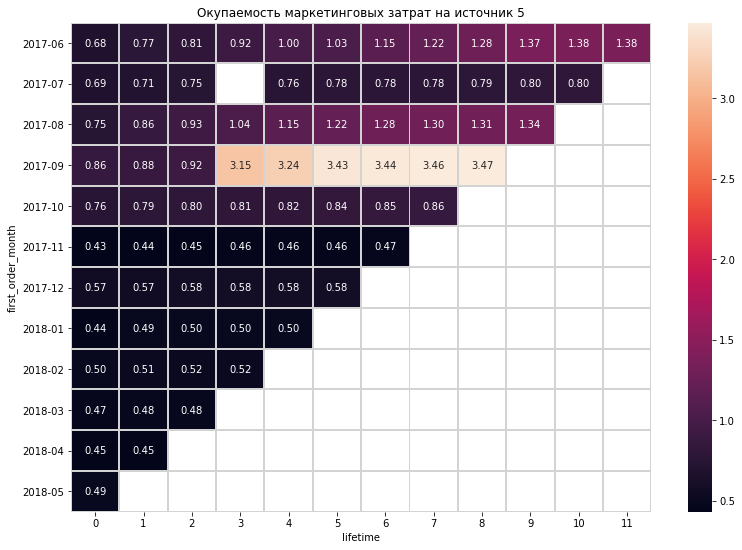

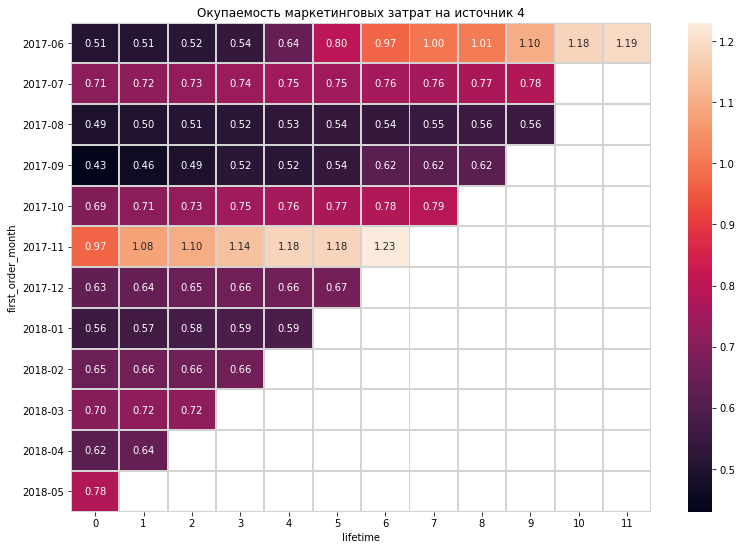

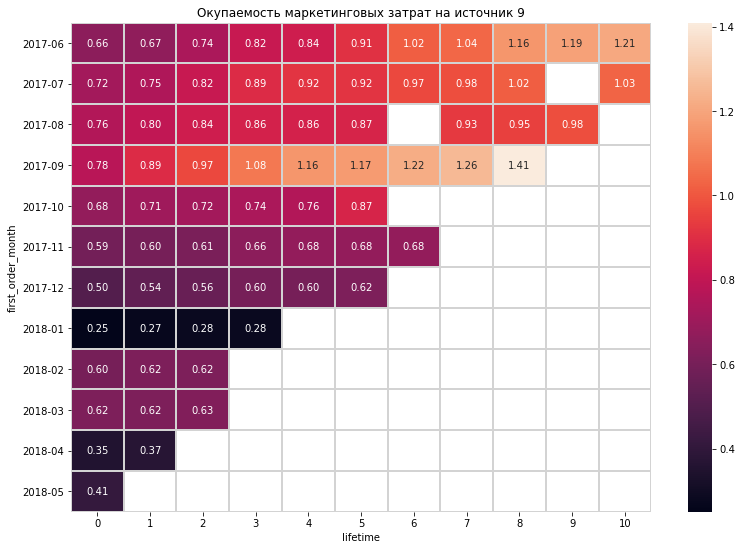

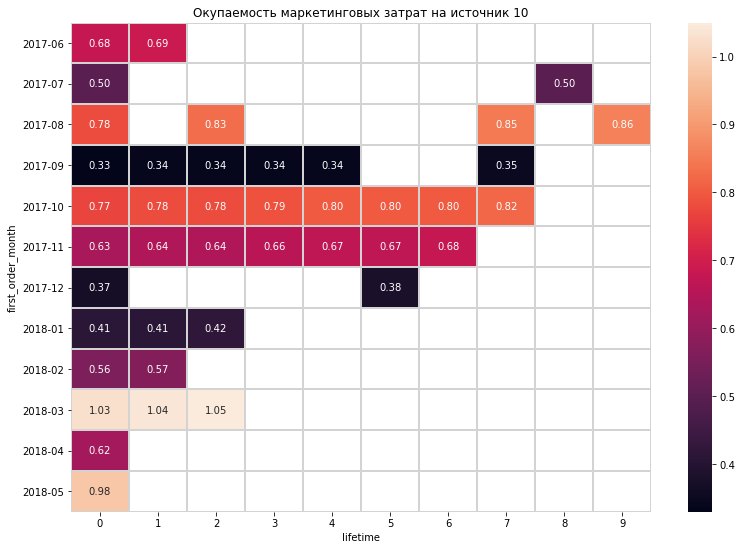

In [156]:
for source in sources:
    romi_pivot = create_romi_pivot(source)
    plt.figure(figsize=(13,9))
    plt.title('Окупаемость маркетинговых затрат на источник {}'.format(source))
    sns.heatmap(romi_pivot, annot=True, linewidth=1,
               linecolor='lightgray', fmt='.2f');

Всего на привлечение клиентов потрачено 329131,62 денежных единиц.  
Почти 43% этой суммы потрачено на третий источник привлечения.  
Маркетинговые расходы на большинство источников в ноябре резко отличаются от расходов в остальные месяцы.  
В целом по проекту окупилсь только июньская и сентябрьская когорты.  
Третий источник показывает наихудшие результаты по окупаемости.  
Наилучшие показатели окупаемости у клиентов июньской и июльской когорт, привлеченных из первого источника.  


[К содержанию](#Содержание)
<a id='step4'></a>

# 4. Вывод

* Число визитов и покупок резко возрастает к декабрю и падает в апреле, в то время как макисмум маркетинговых затрат приходится именно на ноябрь для большинства источников. Возможно, для обеспечения стабильного спроса следует более равномерно распределять маркетинговые мероприятия в течение года.
* Что касается устройств, с планшетов заходят и совершают покупки стабильнее и гораздо меньше. Можно порекомендовать отдельно изучить удобство версии сервиса для планшетов.  
* По количеству визитов и количеству покупок наиболее перспективными казались источники 3, 4 и 5, но изучение среднего чека, LTV за шесть месяцев и окупаемости показало, что затраты на третий источник являются неоправданно завышенными и их следует пересмотреть. Наиболее перспективными по прибыльности и окупаемости являются источники 2, 1 и 5.  